In [1]:
## opencv 설치
!pip install opencv-python  

In [11]:
## 정상인 사진과 녹내장인 사진의 분류
## 현재 작업하는 디렉토리 아래에 G1020 이미지가 있다고 가정
import os
import pandas as pd
import shutil

file_path = './G1020/G1020.csv'

df = pd.read_csv(file_path)

normal_dir = './Normal_images_cropped/'
glaucoma_dir = './Glaucoma_images_cropped/'

if not os.path.exists(normal_dir):
    os.makedirs(normal_dir)
if not os.path.exists(glaucoma_dir):
    os.makedirs(glaucoma_dir)

i = 0
while (i < len(df)):
    src = './G1020/Images_Cropped/img/'+df['imageID'][i]
    if (df['binaryLabels'][i]) == 0:
        des = normal_dir
    else:
        des = glaucoma_dir
    des = des + df['imageID'][i]
    shutil.copy(src, des)
    i = i + 1

In [13]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *

class DeepConvNet:
    """정확도 99% 이상의 고정밀 합성곱 신경망

    네트워크 구성은 아래와 같음
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        affine - relu - dropout - affine - dropout - softmax
    """
    def __init__(self, input_dim=(1, 64, 64),
                 conv_param_1 = {'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_2 = {'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_3 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_4 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_5 = {'filter_num':128, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_6 = {'filter_num':128, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=50, output_size=2):
        # 가중치 초기화===========
        # 각 층의 뉴런 하나당 앞 층의 몇 개 뉴런과 연결되는가（TODO: 자동 계산되게 바꿀 것）
        pre_node_nums = np.array([1*3*3, 32*3*3, 32*3*3, 364*3*3, 64*3*3, 128*3*3, 128*8*8, hidden_size])
        wight_init_scales = np.sqrt(2.0 / pre_node_nums)  # ReLU를 사용할 때의 권장 초깃값
        
        self.params = {}
        pre_channel_num = input_dim[0]
        for idx, conv_param in enumerate([conv_param_1, conv_param_2, conv_param_3, conv_param_4, conv_param_5, conv_param_6]):
            self.params['W' + str(idx+1)] = wight_init_scales[idx] * np.random.randn(conv_param['filter_num'], pre_channel_num, conv_param['filter_size'], conv_param['filter_size'])
            self.params['b' + str(idx+1)] = np.zeros(conv_param['filter_num'])
            pre_channel_num = conv_param['filter_num']
        self.params['W7'] = wight_init_scales[6] * np.random.randn(128*8*8, hidden_size)
        self.params['b7'] = np.zeros(hidden_size)
        self.params['W8'] = wight_init_scales[7] * np.random.randn(hidden_size, output_size)
        self.params['b8'] = np.zeros(output_size)

        # 계층 생성===========
        self.layers = []
        self.layers.append(Convolution(self.params['W1'], self.params['b1'], 
                           conv_param_1['stride'], conv_param_1['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W2'], self.params['b2'], 
                           conv_param_2['stride'], conv_param_2['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Convolution(self.params['W3'], self.params['b3'], 
                           conv_param_3['stride'], conv_param_3['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W4'], self.params['b4'],
                           conv_param_4['stride'], conv_param_4['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Convolution(self.params['W5'], self.params['b5'],
                           conv_param_5['stride'], conv_param_5['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W6'], self.params['b6'],
                           conv_param_6['stride'], conv_param_6['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Affine(self.params['W7'], self.params['b7']))
        self.layers.append(Relu())
        self.layers.append(Dropout(0.5))
        self.layers.append(Affine(self.params['W8'], self.params['b8']))
        self.layers.append(Dropout(0.5))
        
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x, train_flg=False):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x, train_flg=True)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx, train_flg=False)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        tmp_layers = self.layers.copy()
        tmp_layers.reverse()
        for layer in tmp_layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            grads['W' + str(i+1)] = self.layers[layer_idx].dW
            grads['b' + str(i+1)] = self.layers[layer_idx].db

        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            self.layers[layer_idx].W = self.params['W' + str(i+1)]
            self.layers[layer_idx].b = self.params['b' + str(i+1)]

In [7]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter

normal_dir = os.path.join('.', 'Normal_images_cropped')
glaucoma_dir = os.path.join('.','Glaucoma_images_cropped')
    
normal_files = glob.glob(normal_dir+'/*.jpg')
glaucoma_files = glob.glob(glaucoma_dir+'/*.jpg')

np.random.seed(42)

files_df = pd.DataFrame({
    'filename': normal_files + glaucoma_files,
    'label': [1] * len(glaucoma_files) + [0] * len(normal_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

train_files, test_files, train_labels, test_labels =  train_test_split(files_df['filename'].values,
                                                                       files_df['label'].values,
                                                                       test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, test_size=0.1, random_state=42)

#print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

def make_data(filenames):
    data_map = []
    for imgfname in filenames:
        img = cv2.imread(imgfname)
        img = cv2.resize(img, (64,64), interpolation=cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = np.expand_dims(img, axis = -1)
        data_map.append(img)        
    return np.array(data_map)

train_data = make_data(train_files)
val_data = make_data(val_files)
test_data = make_data(test_files)

#print(train_data.shape)
#imgplot = plt.imshow(test_data[10])
#plt.show()

train_data = train_data.transpose(0,3,1,2)
test_data = test_data.transpose(0,3,1,2)

train loss:-9.999999505838704e-08
=== epoch:1, train acc:0.8791208791208791, test acc:0.9174311926605505 ===
train loss:6.863126406847042
train loss:0.13862931611199703
train loss:3.500877882415652
train loss:-9.999999505838704e-08
train loss:0.27725873222398917
train loss:3.500877882415652
train loss:0.2772587322239891
train loss:-9.999999505838704e-08
train loss:-9.999999505838704e-08
train loss:-9.999999505838704e-08
train loss:3.500877860502219
train loss:0.41588814833598126
train loss:0.13862931611199703
train loss:0.27725873268479406
train loss:0.13862931611199703
train loss:0.41588814833598126
train loss:0.13862931611199703
train loss:-9.999999505838704e-08
train loss:0.13862931611199703
train loss:0.23283036012924924
train loss:-9.999999505838704e-08
train loss:0.138629316112185
train loss:0.2772587322239891
train loss:-9.999999505838704e-08
train loss:-9.999999505838704e-08
train loss:0.2772587322239891
train loss:0.277258732226579
train loss:0.13862931611199703
train loss:0.2

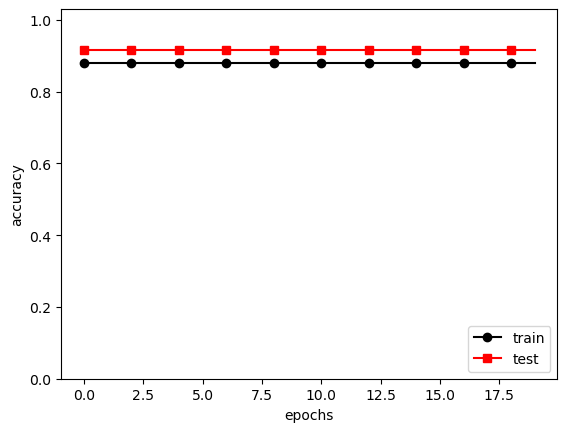

caluculate accuracy (float64) ... 
0.9174311926605505


In [9]:
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
#from deep_convnet import DeepConvNet
from common.trainer import Trainer
#(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

(x_train, t_train) = (train_data, train_labels)
(x_test, t_test) = (test_data, test_labels)

network = DeepConvNet()  
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=20, mini_batch_size=5,
                  optimizer='Adam', optimizer_param={'lr':0.001},
                  evaluate_sample_num_per_epoch=None)
trainer.train()

# 매개변수 보관
#network.save_params("deep_convnet_params.pkl")
# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
#x = np.arange(max_epochs)
x = np.arange(len(trainer.train_acc_list))

plt.plot(x, trainer.train_acc_list, color='k', marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, color='r', marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.03)
plt.legend(loc='lower right')
plt.show()

print("caluculate accuracy (float64) ... ")
print(network.accuracy(x_test, t_test))